In [1]:
import sys
sys.path.append('../../../src')
from helpers import *
import scipy.stats as st
import random
random.seed(12345)
%matplotlib notebook

### Import data, summarise quantification

In [2]:
df = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/NEBD_Embryos_dataframe.csv')
df_quantification = pd.read_csv('../../Raw analysis/PAR-2 NEBD quantification/QUANTIFICATION.csv')
df_quantification_grouped = df_quantification.groupby('EmbryoID')

df_summary = pd.DataFrame()
for i, r in df_quantification_grouped:
    cyt = np.mean(r['Cytoplasmic signal'])
    mem_tot = np.mean(r['Membrane signal'])
    mem_ant = bounded_mean_1d(r['Membrane signal'], [0.4, 0.6])
    mem_post = bounded_mean_1d(r['Membrane signal'], [0.9, 0.1]) 
    p = {'EmbryoID': i, 'Cyt': cyt, 'Mem_tot': mem_tot, 'Mem_ant': mem_ant, 'Mem_post': mem_post} 
    df_summary = df_summary.append(pd.DataFrame(p, index=[i]))
df = pd.merge(df, df_summary, on='EmbryoID')

# Filter
df = df[df.Line.isin(['lp637', 'nwg201', 'nwg240', 'nwg246', 'nwg338', 'nwg369', 'nwg376', 'nwg437'])]

# # Remove points below threshold
# mem_thresh = 4e2
# cyt_thresh = 2e2
# df = df[df.Mem_post > mem_thresh]
# df = df[df.Cyt > cyt_thresh]

# Add uniform vs polarised column
unipol = ['Pol' if x in ['lp637', 'nwg240', 'nwg338', 'nwg376'] else 'Uni' for x in df.Line]
df['UniPol'] = unipol

# Add genotype column
genotype = ['WT' if x in ['lp637', 'nwg201'] else 'C56S' if x in ['nwg240', 'nwg246'] else 'L109R' if x in ['nwg338', 'nwg369'] else 'GCN4' for x in df.Line]
df['Genotype'] = genotype

df

,Unnamed: 0,Path,EmbryoID,Line,Date,RNAi,Cyt,Mem_tot,Mem_ant,Mem_post,UniPol,Genotype
0,0,/Users/blandt/Desktop/PaperData//Imaging/PAR-2...,1580292350,lp637,200129,wt,1905.8176,21047.143478,-382.695108,49073.503577,Pol,WT
1,1,/Users/blandt/Desktop/PaperData//Imaging/PAR-2...,1580292382,lp637,200129,wt,1773.6985,20085.180528,-457.248248,48638.710179,Pol,WT
2,2,/Users/blandt/Desktop/PaperData//Imaging/PAR-2...,1580292449,lp637,200129,wt,1747.8225,19632.492555,-484.477601,47666.740236,Pol,WT
3,3,/Users/blandt/Desktop/PaperData//Imaging/PAR-2...,1580292501,lp637,200129,wt,1750.2806,19798.174908,-502.926816,47007.759712,Pol,WT
4,4,/Users/blandt/Desktop/PaperData//Imaging/PAR-2...,1580292520,lp637,200129,wt,1738.4486,19679.499981,-505.556818,46303.485298,Pol,WT
...,...,...,...,...,...,...,...,...,...,...,...,...
652,652,/Users/blandt/Desktop/PaperData//Imaging/PAR-2...,1662143752,nwg376,220902,2209020830par2,1338.8955,5355.256422,2180.890385,8556.466386,Pol,GCN4
653,653,/Users/blandt/Desktop/PaperData//Imaging/PAR-2...,1662143805,nwg376,220902,2209020830par2,1750.6221,7644.888397,954.015362,13136.051434,Pol,GCN4
654,654,/Users/blandt/Desktop/PaperData//Imaging/PAR-2...,1662143923,nwg338,220902,2209020830par2,2488.3710,4244.196591,-53.258666,12125.048920,Pol,L109R
655,655,/Users/blandt/Desktop/PaperData//Imaging/PAR-2...,1662143984,nwg338,220902,2209020830par2,2147.0781,2992.826677,122.387463,8037.867507,Pol,L109R


###  Fitting functions

In [3]:
import scipy.odr as odr
from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b

def single_fit(cyt, mem):
    p = np.polyfit(cyt, mem, 1)
    return p

def bootstrap_fitting(cyts, mems, n=1000):
    params = np.zeros([n, 2])
    for i in range(n):  
        inds = np.random.choice(range(len(cyts)), len(cyts))
        params[i, :] = single_fit(cyts[inds], mems[inds])
    return params

class ExponentConfidenceInterval:
    def __init__(self, df, whole_embryo=False, xmin=None, xmax=None, n_x=100):
        # Input
        self.cyts = np.log10(df.Cyt.to_numpy())
        if not whole_embryo:
            self.mems = np.log10(df.Mem_post.to_numpy())
        else:
            self.mems = np.log10(df.Mem_tot.to_numpy())
        self.unipol = df.UniPol.tolist()
        
        if xmin is None:
            xmin = min(self.cyts)
        if xmax is None:
            xmax = max(self.cyts)
        self.res_x = np.linspace(xmin, xmax, n_x)
        
        # Run
        self.run()
        
    def run(self, n_bootstrap=1000, interval=95):

        # Analysing full dataset
        popt_full = single_fit(self.cyts, self.mems)
        self.res_y = linear_model(self.res_x, *popt_full)
        self.exponent_full = popt_full[0]

        # Bootstrapping
        params = bootstrap_fitting(self.cyts, self.mems)
        self.exponents = params[:, 0]

        # Confidence interval
        all_fits = np.zeros([n_bootstrap, len(self.res_x)])
        for i, p in enumerate(params):
            all_fits[i, :] = linear_model(self.res_x, *p)
        self.all_fits_lower = np.percentile(all_fits, (100 - interval) / 2, axis=0)
        self.all_fits_upper = np.percentile(all_fits, 50 + (interval / 2), axis=0)

### Analysis

In [4]:
analysisWT_pooled = ExponentConfidenceInterval(df[df.Line.isin(['lp637', 'nwg201'])])
analysisC56S_pooled = ExponentConfidenceInterval(df[df.Line.isin(['nwg240', 'nwg246'])])
analysisL109R_pooled = ExponentConfidenceInterval(df[df.Line.isin(['nwg338', 'nwg369'])])
analysisGCN4_pooled = ExponentConfidenceInterval(df[df.Line.isin(['nwg376', 'nwg437'])])

analysisWT_polarised = ExponentConfidenceInterval(df[df.Line.isin(['lp637'])])
analysisC56S_polarised = ExponentConfidenceInterval(df[df.Line.isin(['nwg240'])])
analysisL109R_polarised = ExponentConfidenceInterval(df[df.Line.isin(['nwg338'])])
analysisGCN4_polarised = ExponentConfidenceInterval(df[df.Line.isin(['nwg376'])])

analysisWT_uniform = ExponentConfidenceInterval(df[df.Line.isin(['nwg201'])])
analysisC56S_uniform = ExponentConfidenceInterval(df[df.Line.isin(['nwg246'])])
analysisL109R_uniform = ExponentConfidenceInterval(df[df.Line.isin(['nwg369'])])
analysisGCN4_uniform = ExponentConfidenceInterval(df[df.Line.isin(['nwg437'])])

analysisWT_uniform2 = ExponentConfidenceInterval(df[df.Line.isin(['nwg201'])], whole_embryo=True)
analysisC56S_uniform2 = ExponentConfidenceInterval(df[df.Line.isin(['nwg246'])], whole_embryo=True)
analysisL109R_uniform2 = ExponentConfidenceInterval(df[df.Line.isin(['nwg369'])], whole_embryo=True)
analysisGCN4_uniform2 = ExponentConfidenceInterval(df[df.Line.isin(['nwg437'])], whole_embryo=True)

### Plotting functions

In [5]:
class random_grouped_scatter:
    def __init__(self, linewidth=0.1, edgecolors='k', s=20):
        self.points = []
        self.linewidth = linewidth
        self.edgecolors = edgecolors
        self.s = s
    
    def add(self, x, y, color):
        for _x, _y in zip(x, y):
            self.points.append({'x':_x, 'y':_y, 'color':color})
    
    def plot(self, ax):
        random.shuffle(self.points)
        for p in self.points:
            ax.scatter(p['x'], p['y'], linewidth=self.linewidth, edgecolors=self.edgecolors, s=self.s, 
                       color=p['color'])

def plot_rundown_ci(ax, res, color):
    ax.plot(res.res_x, res.res_y, c='k', zorder=100, linewidth=1)
    ax.fill_between(res.res_x, res.all_fits_lower, res.all_fits_upper, alpha=0.1, color='k', zorder=100)
    ax.set_xlabel('Cytoplasmic conc. (a.u.)', fontsize=9)
    ax.set_ylabel('Membrane conc. (a.u.)', fontsize=9)
    ax.tick_params(axis='both', labelsize=8)
    b = np.array([r == 'Pol' for r in res.unipol])
    r = random_grouped_scatter()
    r.add(res.cyts[~b], res.mems[~b], color=lighten(color))
    r.add(res.cyts[b], res.mems[b], color=color)
    r.plot(ax)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for i in np.arange(-10, 10, 0.5):
        ax.plot([-10, 10], [i - 10, i + 10], c='0.9', zorder=-100, linewidth=1)
    ax.set_xticks(np.arange(0, 10))
    ax.set_yticks(np.arange(0, 10))
    minor_ticks(ax, [0, 10], [0, 10])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(fake_log)
    ax.yaxis.set_major_formatter(fake_log) 

    
def violin(ax, res, xpos, color):
    kde = st.gaussian_kde(res.exponents)
    xx = np.linspace(min(res.exponents), max(res.exponents), 1000)
    kde_xx = kde(xx)
    ax.fill_betweenx(xx, xpos - 0.8 * (kde_xx / max(kde_xx)), 
                     xpos + 0.8 * (kde_xx / max(kde_xx)), color=color, linewidth=0)
    ax.plot([xpos, xpos], [np.percentile(res.exponents, 2.5), np.percentile(res.exponents, 97.5)], c='k', 
            linewidth=0.5)
    ax.scatter(xpos, res.exponent_full, c='k', s=5)

### Full figure

In [6]:
def full_figure(analysisWT, analysisC56S, analysisL109R):
    # Create figure
    fig, ax = plt.subplots(1, 4)

    # WT rundown
    plot_rundown_ci(ax[0], analysisWT, 'tab:blue')
    ax[0].set_ylim(2, 5)
    ax[0].set_aspect('equal', adjustable='datalim')

    # C56S rundown
    plot_rundown_ci(ax[1], analysisC56S, 'tab:orange')
    ax[1].set_ylim(2, 5)
    ax[1].set_aspect('equal', adjustable='datalim')

    # L109R rundown
    plot_rundown_ci(ax[2], analysisL109R, 'tab:green')
    ax[2].set_ylim(2, 5)
    ax[2].set_aspect('equal', adjustable='datalim')

    # Violin plot
    violin(ax[3], analysisWT, 1, 'tab:blue')
    violin(ax[3], analysisC56S, 3, 'tab:orange')
    violin(ax[3], analysisL109R, 5, 'tab:green')

    # Tidy violin plot
    ax[3].set_xticks([1, 3, 5])
    ax[3].set_xticklabels(['WT', 'C56S', 'L109R'])
    for tick in ax[3].get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment('right')
    ax[3].set_ylabel('Cooperativity')
    ax[3].tick_params(axis='both', labelsize=8)
    ax[3].set_ylim()
    ax[3].axhline(1, color='k', linestyle='--', zorder=-100, linewidth=1)

    # Tidy figure
    fig.set_size_inches(10, 2.8)
    fig.subplots_adjust(left=0.08, wspace=0.6, bottom=0.3, right=0.95)
    return fig

### Analysis

<IPython.core.display.Javascript object>


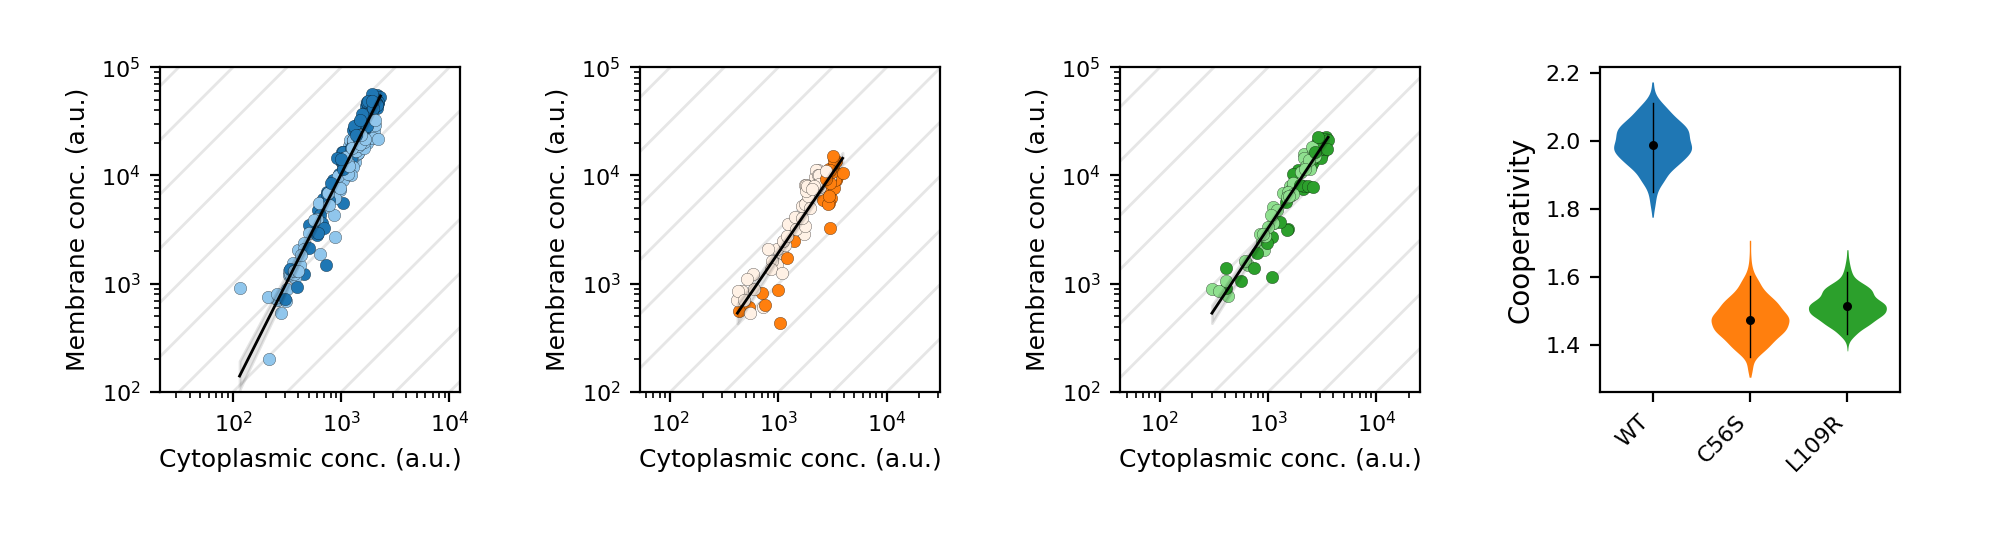

In [7]:
# Pooled
fig = full_figure(analysisWT_pooled, analysisC56S_pooled, analysisL109R_pooled)
fig.savefig('Figs/log_ols_pooled.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


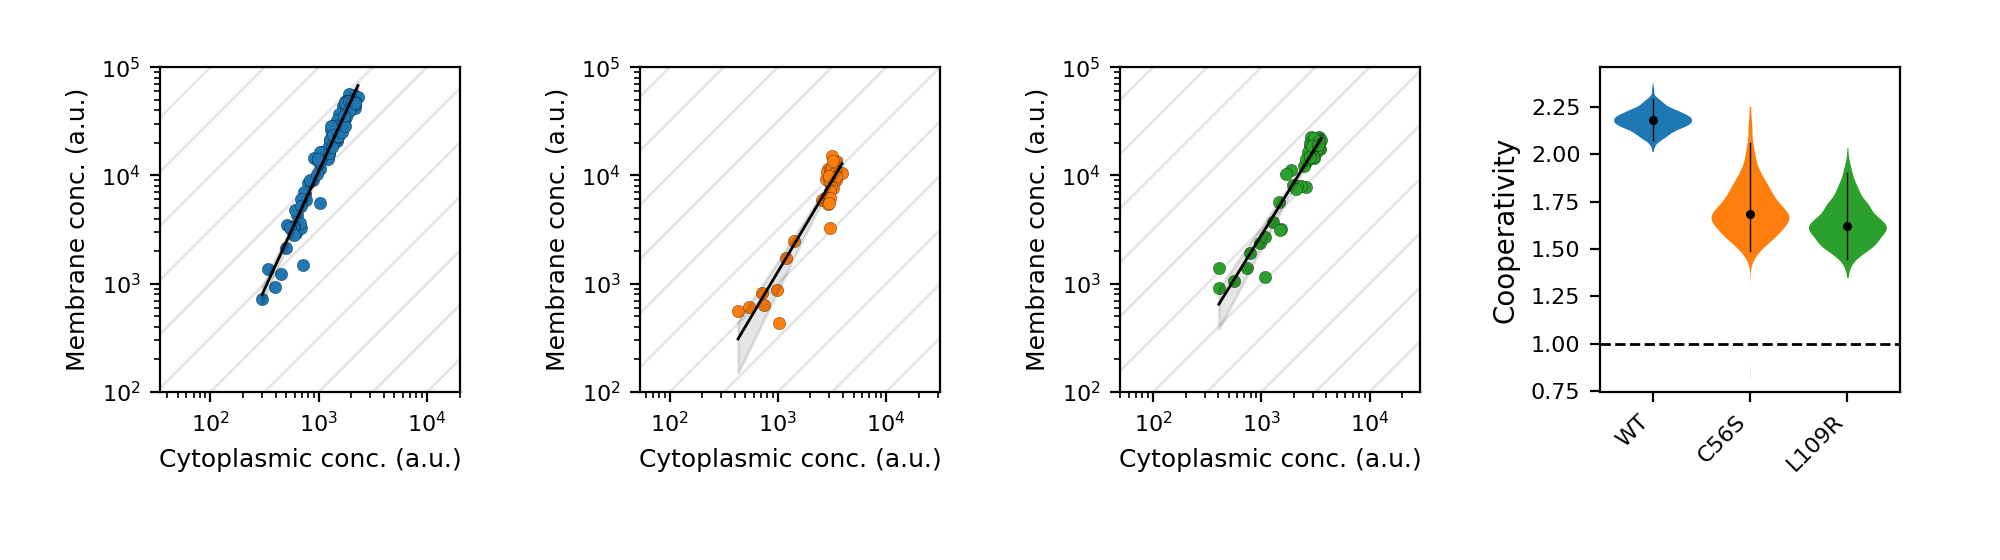

In [8]:
# Polarised
fig = full_figure(analysisWT_polarised, analysisC56S_polarised, analysisL109R_polarised)
fig.savefig('Figs/log_ols_polarised.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


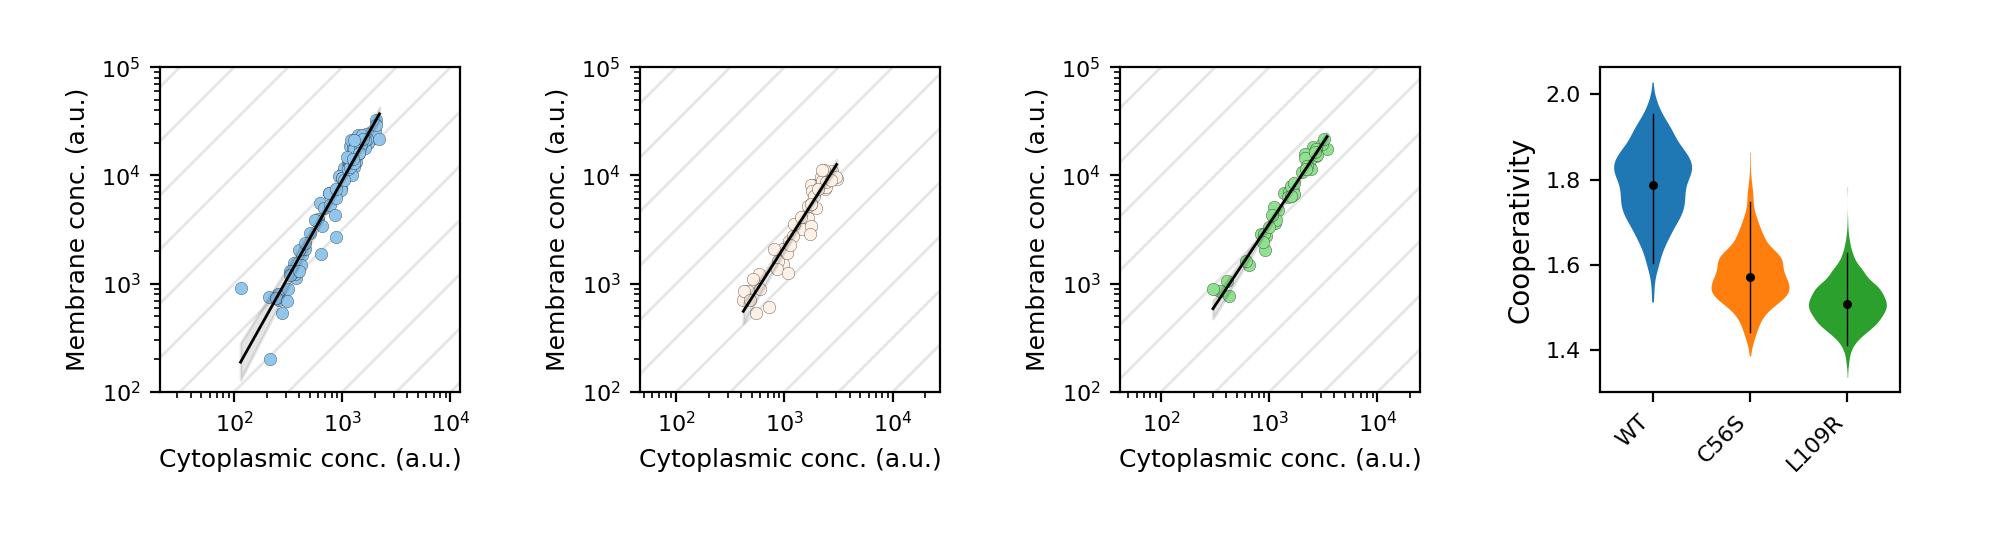

In [9]:
# Uniform
fig = full_figure(analysisWT_uniform, analysisC56S_uniform, analysisL109R_uniform)
fig.savefig('Figs/log_ols_uniform.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


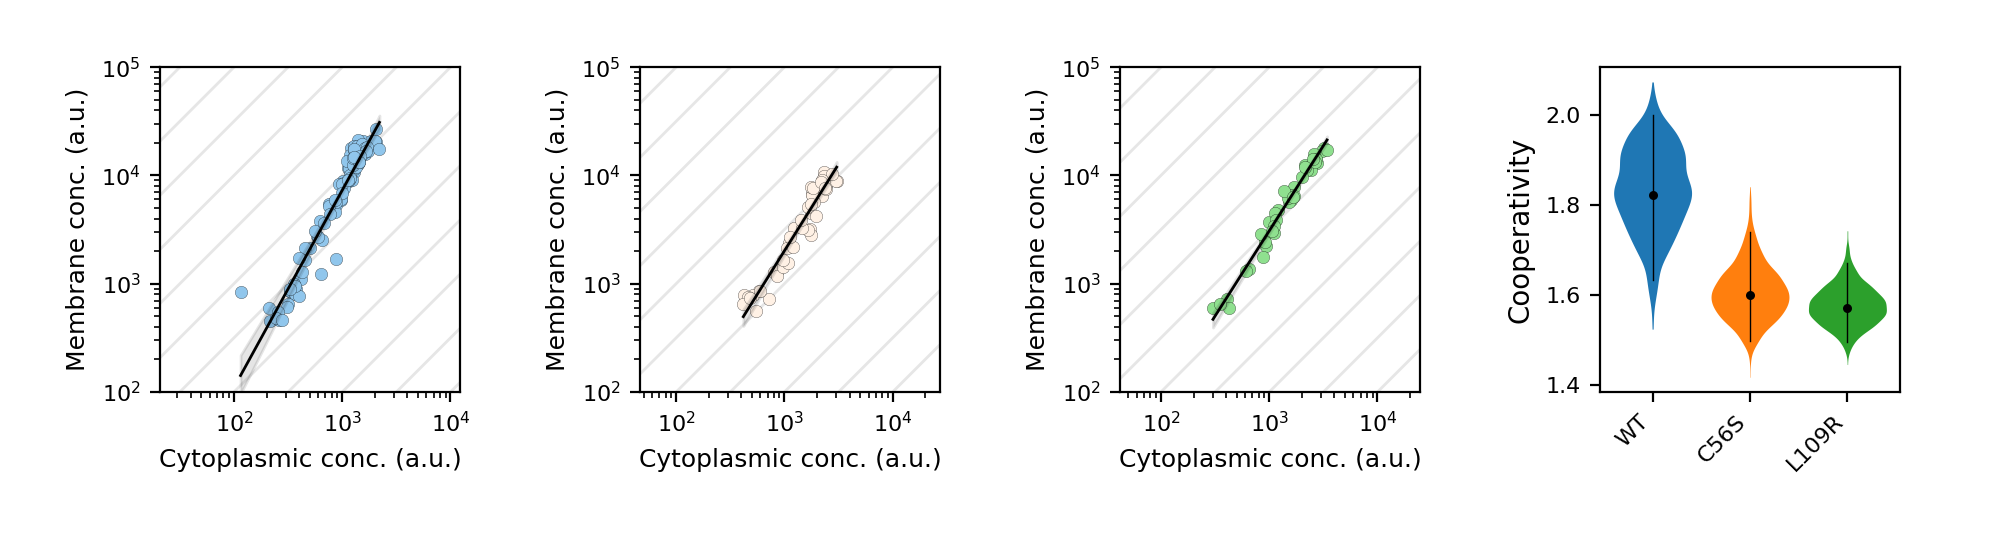

In [10]:
# Uniform (whole embryo)
fig = full_figure(analysisWT_uniform2, analysisC56S_uniform2, analysisL109R_uniform2)
fig.savefig('Figs/log_ols_uniform_whole_embryo.png', dpi=600, transparent=True)

### For paper

<IPython.core.display.Javascript object>


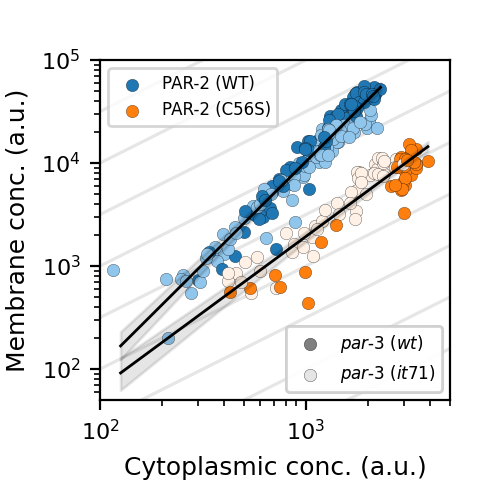

In [11]:
analysisWT = ExponentConfidenceInterval(df[df.Line.isin(['lp637', 'nwg201'])], xmin=2.1)
analysisC56S = ExponentConfidenceInterval(df[df.Line.isin(['nwg240', 'nwg246'])], xmin=2.1)

fig, ax = plt.subplots()
plot_rundown_ci(ax, analysisWT, 'tab:blue')
plot_rundown_ci(ax, analysisC56S, 'tab:orange')
s1 = ax.scatter([], [], color='tab:blue', linewidth=0.1, edgecolors='k', s=20)
s2 = ax.scatter([], [], color='tab:orange', linewidth=0.1, edgecolors='k', s=20)
legend1 = ax.legend([s1, s2], ['PAR-2 (WT)', 'PAR-2 (C56S)'], fontsize=6, loc='upper left')
s3 = ax.scatter([], [], color='tab:gray', linewidth=0.1, edgecolors='k', s=20)
s4 = ax.scatter([], [], color=lighten('tab:gray'), linewidth=0.1, edgecolors='k', s=20)
legend2 = ax.legend([s3, s4], [r'$par$' +'-' + r'$3\ (wt)$', r'$par$' +'-' + r'$3\ (it71)$'],
                    fontsize=6, loc='lower right')

ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlim(2, 3.7)
ax.set_ylim(1.7, 5)
fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2)
fig.savefig('Figs/for_paper_c56s_rundown.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


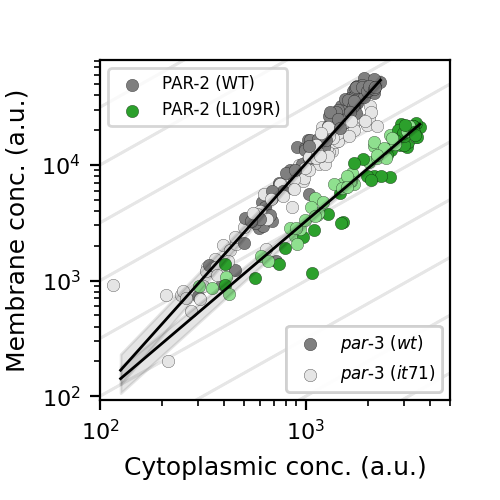

In [12]:
analysisWT = ExponentConfidenceInterval(df[df.Line.isin(['lp637', 'nwg201'])], xmin=2.1)
analysisL109R = ExponentConfidenceInterval(df[df.Line.isin(['nwg338', 'nwg369'])], xmin=2.1)

fig, ax = plt.subplots()
plot_rundown_ci(ax, analysisWT, 'tab:gray')
plot_rundown_ci(ax, analysisL109R, 'tab:green')
s1 = ax.scatter([], [], color='tab:gray', linewidth=0.1, edgecolors='k', s=20)
s2 = ax.scatter([], [], color='tab:green', linewidth=0.1, edgecolors='k', s=20)
legend1 = ax.legend([s1, s2], ['PAR-2 (WT)', 'PAR-2 (L109R)'], fontsize=6, loc='upper left')
s3 = ax.scatter([], [], color='tab:gray', linewidth=0.1, edgecolors='k', s=20)
s4 = ax.scatter([], [], color=lighten('tab:gray'), linewidth=0.1, edgecolors='k', s=20)
legend2 = ax.legend([s3, s4], [r'$par$' +'-' + r'$3\ (wt)$', r'$par$' +'-' + r'$3\ (it71)$'],
                    fontsize=6, loc='lower right')
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlim(2, 3.7)
fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2)
fig.savefig('Figs/for_paper_l109r_rundown.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


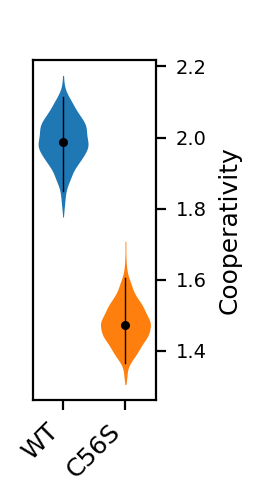

In [13]:
fig, ax = plt.subplots(1)

violin(ax, analysisWT_pooled, 1, 'tab:blue')
violin(ax, analysisC56S_pooled, 3, 'tab:orange')

ax.set_xticks([1, 3])
ax.set_xticklabels(['WT', 'C56S'])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
ax.set_ylabel('Cooperativity', fontsize=9)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=9)
ax.set_ylim()
ax.axhline(1, color='k', linestyle='--', zorder=-100, linewidth=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.set_size_inches(1.3, 2.5)
fig.subplots_adjust(bottom=0.2, right=0.6)
fig.savefig('Figs/for_paper_exponents.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


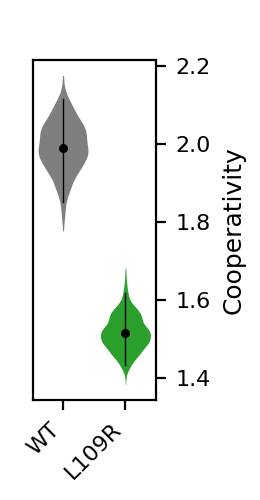

In [14]:
fig, ax = plt.subplots(1)

violin(ax, analysisWT_pooled, 1, 'tab:gray')
violin(ax, analysisL109R_pooled, 3, 'tab:green')

ax.set_xticks([1, 3])
ax.set_xticklabels(['WT', 'L109R'])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
ax.set_ylabel('Cooperativity', fontsize=9)
ax.tick_params(axis='both', labelsize=8)
ax.set_ylim()
ax.axhline(1, color='k', linestyle='--', zorder=-100, linewidth=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.set_size_inches(1.3, 2.5)
fig.subplots_adjust(bottom=0.2, right=0.6)
fig.savefig('Figs/for_paper_exponents_l109r.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


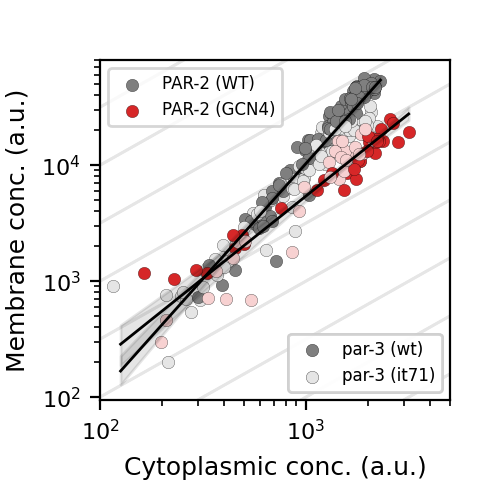

In [15]:
analysisWT = ExponentConfidenceInterval(df[df.Line.isin(['lp637', 'nwg201'])], xmin=2.1)
analysisGCN4 = ExponentConfidenceInterval(df[df.Line.isin(['nwg376', 'nwg437'])], xmin=2.1)

fig, ax = plt.subplots()
plot_rundown_ci(ax, analysisWT, 'tab:gray')
plot_rundown_ci(ax, analysisGCN4, 'tab:red')
s1 = ax.scatter([], [], color='tab:gray', linewidth=0.1, edgecolors='k', s=20)
s2 = ax.scatter([], [], color='tab:red', linewidth=0.1, edgecolors='k', s=20)
legend1 = ax.legend([s1, s2], ['PAR-2 (WT)', 'PAR-2 (GCN4)'], fontsize=6, loc='upper left')
s3 = ax.scatter([], [], color='tab:gray', linewidth=0.1, edgecolors='k', s=20)
s4 = ax.scatter([], [], color=lighten('tab:gray'), linewidth=0.1, edgecolors='k', s=20)
legend2 = ax.legend([s3, s4], ['par-3 (wt)', 'par-3 (it71)'], fontsize=6, loc='lower right')
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlim(2, 3.7)
fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(left=0.2, bottom=0.2)
fig.savefig('Figs/for_paper_gcn4_rundown.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


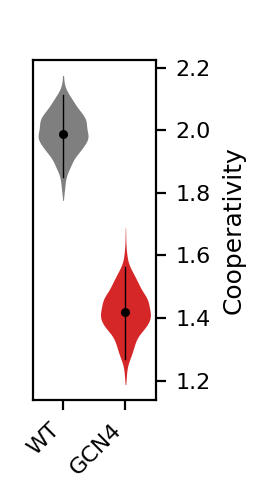

In [16]:
fig, ax = plt.subplots(1)

violin(ax, analysisWT_pooled, 1, 'tab:gray')
violin(ax, analysisGCN4_pooled, 3, 'tab:red')

ax.set_xticks([1, 3])
ax.set_xticklabels(['WT', 'GCN4'])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
ax.set_ylabel('Cooperativity', fontsize=9)
ax.tick_params(axis='both', labelsize=8)
ax.set_ylim()
ax.axhline(1, color='k', linestyle='--', zorder=-100, linewidth=1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

fig.set_size_inches(1.3, 2.5)
fig.subplots_adjust(bottom=0.2, right=0.6)
fig.savefig('Figs/for_paper_exponents_gcn4.png', dpi=600, transparent=True)